In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
import string

import os
from flask import Flask, request, render_template
import json
import h5py 

In [2]:
#initialization
stop = stopwords.words('english')
symbols = list(string.punctuation)
app = Flask(__name__)

In [3]:
# load the data
data = pd.read_csv('labeledTrainData.tsv', sep="\t")

In [4]:
# displaying head
data.head()

,id,sentiment,review
0,1,1,This movie is great!
1,2,0,The acting was terrible.
2,3,1,I loved the plot twists.
3,4,0,The movie was boring.


In [5]:
# data preprocessing
def cleaning(raw):
    htmlFree = BeautifulSoup(raw, "html.parser")  # removing html tags
    # removing numbers and others except small and capital alphabets
    letters = re.sub("[^a-zA-Z ]", " ", htmlFree.get_text())
    low = letters.lower()  # Converting everything to lower case
    words = low.split()  # spiliting sentences into words
    cleaned = [w for w in words if not w in stop]  # removing stopping words
    return ' '.join(cleaned)

In [6]:
x = list(map(cleaning, data['review']))
y = data['sentiment']

In [7]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
len(X_train), len(X_test), len(x)

(3, 1, 4)

In [9]:
# EDA
print("Sample Reviews:\n", pd.Series(X_train).head())

Sample Reviews:
 0         movie boring
1          movie great
2    loved plot twists
dtype: object


In [10]:
print("\nSentiment Distribution:\n", data['sentiment'].value_counts(normalize=True))


Sentiment Distribution:
 1    0.5
0    0.5
Name: sentiment, dtype: float64


In [11]:
print("\nReview Length Stats:\n", pd.Series(x).apply(len).describe())


Review Length Stats:
 count     4.000000
mean     13.750000
std       2.753785
min      11.000000
25%      11.750000
50%      13.500000
75%      15.500000
max      17.000000
dtype: float64



Review Length Distribution (by sentiment):



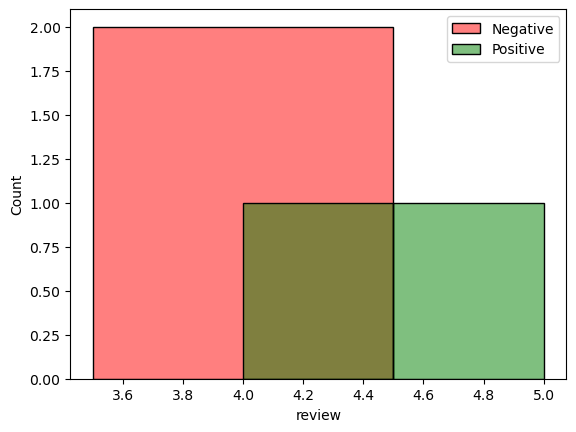

In [12]:
print("\nReview Length Distribution (by sentiment):\n")
sns.histplot(
    data[data['sentiment'] == 0]['review'].apply(lambda x: len(x.split())),
    alpha=0.5,
    label='Negative',
    color='red')
sns.histplot(
    data[data['sentiment'] == 1]['review'].apply(lambda x: len(x.split())),
    alpha=0.5,
    label='Positive',
    color='green')
plt.legend()
plt.show()


Word Frequency Distribution:



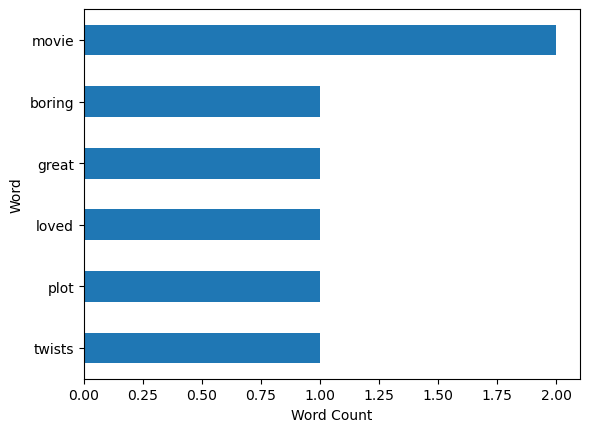

In [13]:
print("\nWord Frequency Distribution:\n")
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_counts = pd.Series(tokenizer.word_counts)
word_counts.sort_values(ascending=False)[:10].plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()

In [14]:
# vectorization
maxlen = 200
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
# model defining
def get_model(model_name):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=maxlen))
    if model_name == "CNN":
        model.add(
            Conv1D(filters=32,
                   kernel_size=3,
                   padding='same',
                   activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
    elif model_name == "LSTM":
        model.add(LSTM(100))
    elif model_name == "BiLSTM":
        model.add(Bidirectional(LSTM(100)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          700       
                                                                 
 conv1d (Conv1D)             (None, 200, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 1)                 3201      
                                                                 
Total params: 13,533
Trainable params: 13,533
Non-trainable params: 0
____________________________________________________

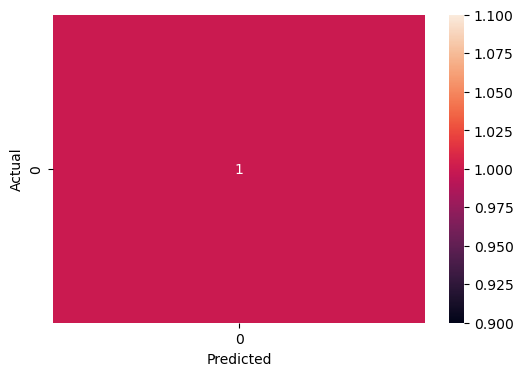

CNN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          700       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 81,2

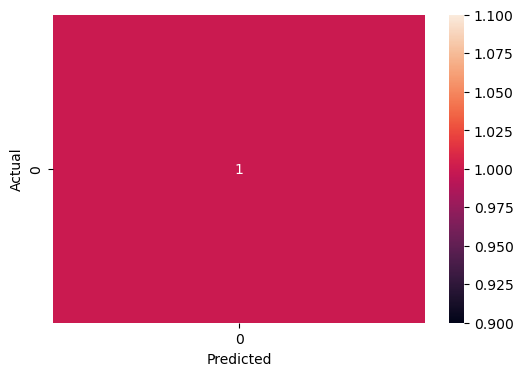

LSTM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          700       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                 

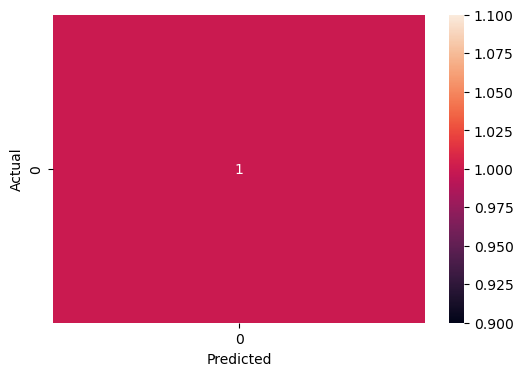

BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [16]:
# model training and evaluation
for model_name in ["CNN", "LSTM", "BiLSTM"]:
    model = get_model(model_name)
    model.summary()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[es])
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    print(model_name, "Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(model_name, "Classification Report:")
    print(classification_report(y_test, y_pred))


In [17]:
# real-time data testing
def predict_sentiment(review):
    review = tokenizer.texts_to_sequences([review])
    review = pad_sequences(review, padding='post', maxlen=maxlen)
    sentiment = model.predict(review)
    if sentiment > 0.5:
        return "Positive"
    else:
        return "Negative"


In [18]:
# example real-time data testing
review = "This movie was great, the acting was superb and the plot was captivating."
print(review)
print(predict_sentiment(review))


This movie was great, the acting was superb and the plot was captivating.
1/1 [==============================] - 0s 43ms/step
Positive


In [23]:
model.save("model.h5")

In [24]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)